In [40]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, least_squares 
from tqdm import tqdm

In [41]:
#Import the SMOL attack csv instead of downsampling
sensor_df_smol = pd.read_csv('../smol_attacks/smol_sim/mules/062.csv')
backbone_sensor_df = sensor_df_smol 
backbone_sensor_df.head()

,sensor ID,norm_secs (secs),time (days)
0,15,11.200029,39423.442618
1,15,11.900031,39423.442626
2,15,12.600032,39423.442634
3,15,13.300034,39423.442642
4,15,14.000036,39423.442650


In [42]:
print(backbone_sensor_df.shape)
print(sensor_df_smol.shape)
print(backbone_sensor_df['sensor ID'].nunique())

(58047, 3)
(58047, 3)
60


In [43]:
#function to check total time between gateways and returns average time
def gateway_total(gateway_x, gateway_y):
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    gateway_path = backbone_sensor_df.values
    
    #hyperparameter
    hops = 5
    
    for x in range(size):
        if (gateway_path[x][0] == gateway_x):
            #if it's in the last few indexes just check the rest
            if ( x > size-hops):
                for i in range(size-x):
                    if (gateway_path[x+i][0] == gateway_y):
                        count += 1
                        time += abs(gateway_path[x-i][1] - gateway_path[x][1])
            #check the next number of hops
            else:
                for i in range(hops):
                    if (gateway_path[x+i][0] == gateway_y):
                        count += 1
                        time += abs(gateway_path[x+i][1] - gateway_path[x][1])
                                        
    if (count >= 1): 
        #print(count)
        return time/count
    else:
        return 0 #could change this to a negative number to indicate doesn't exist 
        
gateway_total(1,20)

0

In [44]:
#set up a matrix of time between adjacent gateways, this is a proxy for distance
num_gates = backbone_sensor_df['sensor ID'].nunique()
time_pairs = np.zeros((num_gates,num_gates))
gateway_ids = backbone_sensor_df['sensor ID'].drop_duplicates().values

for x in tqdm(range(num_gates)):
    #times = []
    for y in range(num_gates):
        #find how many times x gateway is adjacent to y gateway 
        gateway_id_x = gateway_ids[y]
        gateway_id_y = gateway_ids[x]
        average = gateway_total(gateway_id_x,gateway_id_y)

        #add to time_pairs[x][y]
        time_pairs[x][y] = average
        
        
time_pairs

100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


array([[  4.66821057,   4.87509729, 202.12551999, ...,   0.        ,
          0.        ,   0.        ],
       [  8.78430313,   1.46170589, 134.67256869, ...,   0.        ,
         54.60014047,   0.        ],
       [ 64.15785736,  25.83578075,   2.6433772 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  28.63007365,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          1.32310946,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  12.55428066]])

In [45]:
#get the average velocity from the ground truth data 
avg_vel = 2 #m/s

In [46]:
#calculate the distance matrix from the average time and average velocity 
distance = avg_vel*time_pairs
distance
print(distance.shape)

(60, 60)


In [48]:
n_gateways = distance.shape[0]
for g1 in range(n_gateways):
    for g2 in range(n_gateways):
        
        print(g1, g2, distance[g1][g2], distance[g2][g1])

0 0 9.336421136880988 9.336421136880988
0 1 9.750194575195524 17.568606261667973
0 2 404.25103998965994 128.3157147246434
0 3 285.1340668787331 316.400813983212
0 4 448.00115254265836 640.3401088986933
0 5 0.0 0.0
0 6 873.6022474581725 0.0
0 7 0.0 0.0
0 8 322.7008301908783 417.20107330531465
0 9 0.0 0.0
0 10 0.0 0.0
0 11 0.0 0.0
0 12 0.0 0.0
0 13 0.0 0.0
0 14 1182.097158749467 610.4015703393437
0 15 1204.0030974583758 500.8012883780175
0 16 0.0 0.0
0 17 1204.7030992592008 0.0
0 18 1039.8526751595127 0.0
0 19 0.0 0.0
0 20 0.0 0.0
0 21 148.40038177975003 354.20091122901067
0 22 0.0 139.30035836873867
0 23 470.4012101697648 304.4596067923104
0 24 602.8571064857792 0.0
0 25 0.0 52.50013506363515
0 26 0.0 0.0
0 27 0.0 0.0
0 28 699.5351329806581 0.0
0 29 0.0 63.00016207637964
0 30 0.0 0.0
0 31 0.0 0.0
0 32 0.0 1099.7028291320235
0 33 0.0 0.0
0 34 0.0 0.0
0 35 1239.6493430092378 0.0
0 36 519.401336229156 488.6012569918181
0 37 0.0 0.0
0 38 923.3023753183516 1352.4034792381688
0 39 716.3351762

8 46 0.0 0.0
8 47 0.0 0.0
8 48 93.80024131358951 0.0
8 49 0.0 0.0
8 50 0.0 0.0
8 51 576.1014820978089 0.0
8 52 576.8014838986528 0.0
8 53 0.0 0.0
8 54 0.0 0.0
8 55 0.0 0.0
8 56 0.0 0.0
8 57 0.0 0.0
8 58 11.200028813560493 0.0
8 59 0.0 0.0
9 0 0.0 0.0
9 1 0.0 0.0
9 2 1650.6042463993083 0.0
9 3 0.0 0.0
9 4 0.0 0.0
9 5 0.0 0.0
9 6 882.0022690682556 0.0
9 7 0.0 0.0
9 8 0.0 418.60107690705917
9 9 2.479898780677508 2.479898780677508
9 10 54.83106889528494 43.066019883968686
9 11 211.40054385607073 833.0021430090128
9 12 0.0 18.900048622916074
9 13 211.40054385604307 65.80016927970163
9 14 0.0 0.0
9 15 0.0 0.0
9 16 0.0 316.400813983212
9 17 750.4019305089183 0.0
9 18 0.0 0.0
9 19 0.0 0.0
9 20 0.0 0.0
9 21 0.0 0.0
9 22 0.0 0.0
9 23 0.0 0.0
9 24 0.0 0.0
9 25 0.0 0.0
9 26 0.0 0.0
9 27 2.5571494357501825 1.4000036016968078
9 28 0.0 92.40023771190317
9 29 0.0 0.0
9 30 0.0 0.0
9 31 0.0 0.0
9 32 0.0 0.0
9 33 0.0 0.0
9 34 0.0 0.0
9 35 0.0 0.0
9 36 0.0 0.0
9 37 299.1341028956512 133.35034306152411
9 3

23 21 1.71461115264327 1.0753650853621892
23 22 2.5831052369343372 0.8216237353568417
23 23 2.349957265091559 2.349957265091559
23 24 18.16220888688509 42.1078006356239
23 25 106.40027372885088 0.0
23 26 0.0 0.0
23 27 0.0 0.0
23 28 271.83403266258875 0.0
23 29 0.0 0.0
23 30 356.3645531589493 140.00036016951782
23 31 0.0 0.0
23 32 339.2675394776258 0.0
23 33 0.0 0.0
23 34 0.0 0.0
23 35 0.0 0.0
23 36 66.01555444919414 170.80043940682663
23 37 0.0 0.0
23 38 0.0 0.0
23 39 0.0 0.0
23 40 0.0 0.0
23 41 0.0 0.0
23 42 0.0 0.0
23 43 0.0 0.0
23 44 0.0 0.0
23 45 0.0 0.0
23 46 0.0 0.0
23 47 0.0 0.0
23 48 0.0 0.0
23 49 0.0 0.0
23 50 0.0 0.0
23 51 0.0 0.0
23 52 0.0 0.0
23 53 0.0 0.0
23 54 617.9615897885058 0.0
23 55 0.0 0.0
23 56 0.0 0.0
23 57 0.0 0.0
23 58 0.0 0.0
23 59 0.0 0.0
24 0 0.0 602.8571064857792
24 1 0.0 167.8448762477201
24 2 0.0 0.0
24 3 0.0 0.0
24 4 0.0 0.0
24 5 0.0 0.0
24 6 0.0 0.0
24 7 114.8002953390649 0.0
24 8 66.73350501415553 30.644523281585254
24 9 0.0 0.0
24 10 0.0 0.0
24 11 0.0 

31 40 0.0 0.0
31 41 0.0 0.0
31 42 0.0 0.0
31 43 0.0 0.0
31 44 0.0 0.0
31 45 0.0 0.0
31 46 0.0 0.0
31 47 0.0 0.0
31 48 0.0 0.0
31 49 0.0 0.0
31 50 0.0 0.0
31 51 0.0 0.0
31 52 0.0 0.0
31 53 0.0 0.0
31 54 0.0 0.0
31 55 0.0 0.0
31 56 0.0 0.0
31 57 0.0 0.0
31 58 0.0 0.0
31 59 0.0 0.0
32 0 1099.7028291320235 0.0
32 1 341.60087881368815 0.0
32 2 188.00574682773424 428.48681662513025
32 3 0.0 0.0
32 4 323.4008319917164 233.94060184333938
32 5 0.0 0.0
32 6 227.5005852755632 395.5010174790488
32 7 1130.92290944983 233.21112628246956
32 8 0.0 1489.603832204343
32 9 0.0 0.0
32 10 0.0 0.0
32 11 0.0 0.0
32 12 0.0 0.0
32 13 0.0 0.0
32 14 458.03451168810716 111.40028659207539
32 15 73.4839099773781 499.0012837472779
32 16 0.0 245.0006302967522
32 17 946.6494942054716 562.2829280292032
32 18 0.0 0.0
32 19 0.0 0.0
32 20 585.901507309651 693.0017828394161
32 21 0.0 0.0
32 22 0.0 0.0
32 23 0.0 339.2675394776258
32 24 0.0 0.0
32 25 0.0 0.0
32 26 0.0 0.0
32 27 0.0 0.0
32 28 0.0 0.0
32 29 0.0 0.0
32 30 0.0 0

40 0 0.0 0.0
40 1 0.0 0.0
40 2 0.0 0.0
40 3 0.0 0.0
40 4 0.0 0.0
40 5 0.0 0.0
40 6 0.0 0.0
40 7 0.0 0.0
40 8 0.0 0.0
40 9 0.0 0.0
40 10 0.0 0.0
40 11 0.0 0.0
40 12 0.0 0.0
40 13 0.0 0.0
40 14 0.0 0.0
40 15 1758.2489677741387 0.0
40 16 0.0 0.0
40 17 0.0 0.0
40 18 0.0 0.0
40 19 1652.4709178682144 0.0
40 20 0.0 0.0
40 21 0.0 0.0
40 22 0.0 0.0
40 23 0.0 0.0
40 24 0.0 0.0
40 25 0.0 0.0
40 26 0.0 0.0
40 27 0.0 0.0
40 28 0.0 0.0
40 29 0.0 0.0
40 30 0.0 0.0
40 31 0.0 0.0
40 32 0.0 0.0
40 33 0.0 0.0
40 34 0.0 0.0
40 35 0.0 0.0
40 36 0.0 0.0
40 37 0.0 0.0
40 38 0.0 0.0
40 39 0.0 0.0
40 40 2.710098715209207 2.710098715209207
40 41 0.0 759.5387961199541
40 42 0.0 0.0
40 43 414.4010661019653 1502.2038646195956
40 44 1140.3029335811734 0.0
40 45 0.0 0.0
40 46 0.0 0.0
40 47 0.0 0.0
40 48 0.0 0.0
40 49 0.0 0.0
40 50 0.0 0.0
40 51 0.0 0.0
40 52 0.0 0.0
40 53 0.0 0.0
40 54 0.0 0.0
40 55 0.0 0.0
40 56 0.0 0.0
40 57 0.0 0.0
40 58 0.0 0.0
40 59 0.0 0.0
41 0 0.0 0.0
41 1 0.0 0.0
41 2 0.0 0.0
41 3 0.0 0.0
41

48 20 2350.606047247193 648.2016675851307
48 21 0.0 0.0
48 22 0.0 0.0
48 23 0.0 0.0
48 24 0.0 0.0
48 25 0.0 0.0
48 26 0.0 0.0
48 27 0.0 0.0
48 28 0.0 0.0
48 29 0.0 0.0
48 30 0.0 1635.2042067806935
48 31 0.0 0.0
48 32 0.0 0.0
48 33 180.60046461875027 0.0
48 34 0.0 0.0
48 35 0.0 0.0
48 36 0.0 0.0
48 37 70.00018008474144 0.0
48 38 0.0 837.2021538140834
48 39 0.0 0.0
48 40 0.0 0.0
48 41 0.0 0.0
48 42 0.0 0.0
48 43 0.0 0.0
48 44 0.0 0.0
48 45 0.0 0.0
48 46 0.0 0.0
48 47 0.0 0.0
48 48 4.761417715081359 4.761417715081359
48 49 0.0 492.801267796912
48 50 0.0 0.0
48 51 0.0 0.0
48 52 0.0 0.0
48 53 0.0 0.0
48 54 0.0 0.0
48 55 0.0 0.0
48 56 0.0 600.60154512749
48 57 0.0 0.0
48 58 0.0 0.0
48 59 0.0 0.0
49 0 0.0 0.0
49 1 0.0 0.0
49 2 0.0 0.0
49 3 0.0 0.0
49 4 0.0 0.0
49 5 1471.403785382281 0.0
49 6 0.0 0.0
49 7 0.0 0.0
49 8 0.0 0.0
49 9 0.0 0.0
49 10 0.0 0.0
49 11 0.0 0.0
49 12 0.0 0.0
49 13 0.0 0.0
49 14 0.0 0.0
49 15 0.0 0.0
49 16 0.0 0.0
49 17 896.0023050853633 1030.4026508480747
49 18 895.302303

56 40 0.0 0.0
56 41 0.0 0.0
56 42 0.0 0.0
56 43 0.0 0.0
56 44 0.0 0.0
56 45 0.0 0.0
56 46 0.0 0.0
56 47 0.0 0.0
56 48 600.60154512749 0.0
56 49 0.0 0.0
56 50 467.88120368663806 411.6010588985693
56 51 0.0 0.0
56 52 63.00016207632143 0.0
56 53 0.0 0.0
56 54 0.0 0.0
56 55 0.0 0.0
56 56 2.7713079122647732 2.7713079122647732
56 57 0.0 0.0
56 58 6.3000162076205015 18.90004862289934
56 59 0.0 0.0
57 0 0.0 0.0
57 1 0.0 0.0
57 2 0.0 0.0
57 3 0.0 0.0
57 4 0.0 0.0
57 5 0.0 0.0
57 6 0.0 0.0
57 7 0.0 0.0
57 8 0.0 0.0
57 9 0.0 0.0
57 10 0.0 0.0
57 11 0.0 0.0
57 12 0.0 0.0
57 13 0.0 0.0
57 14 0.0 0.0
57 15 0.0 0.0
57 16 0.0 0.0
57 17 0.0 0.0
57 18 0.0 0.0
57 19 0.0 0.0
57 20 0.0 0.0
57 21 0.0 0.0
57 22 0.0 0.0
57 23 0.0 0.0
57 24 0.0 0.0
57 25 0.0 0.0
57 26 0.0 0.0
57 27 0.0 0.0
57 28 0.0 0.0
57 29 0.0 0.0
57 30 0.0 0.0
57 31 0.0 0.0
57 32 1509.203882628039 476.28122529690444
57 33 0.0 0.0
57 34 0.0 0.0
57 35 0.0 0.0
57 36 0.0 0.0
57 37 0.0 0.0
57 38 0.0 0.0
57 39 0.0 0.0
57 40 0.0 0.0
57 41 0.0 0.0

In [31]:
import math

gateway_positions_df = pd.read_csv('../smol_attacks/smol_truth/sensors.csv')

n_gateways = distance.shape[0]
true_distance = np.zeros_like(distance)

for g1 in range(n_gateways):
    for g2 in range(n_gateways):
        
        g1_x, g1_y = gateway_positions_df.iloc[g1]['x (m)'], gateway_positions_df.iloc[g2]['y (m)']
        g2_x, g2_y = gateway_positions_df.iloc[g2]['x (m)'], gateway_positions_df.iloc[g2]['y (m)']
        
        d = math.sqrt((g1_x - g2_x)**2 + (g1_y - g2_y)*2)
        
        true_distance[g1][g2] = d

In [32]:
distance_diff = np.abs(true_distance - distance)

for g1 in range(n_gateways):
    for g2 in range(n_gateways):
        
        if distance[g1][g2] == 0:
            distance_diff[g1][g2] = 0.0


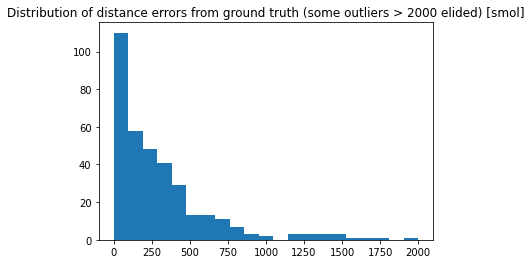

mean distance error (not counting unknown): 64.61 m
quartiles -- 25th: 57.26, 50th: 206.26, 75th: 405.86, 90th: 723.64


In [37]:
import matplotlib.pyplot as plt

distance_diff_vals = []
for g1 in range(n_gateways):
    for g2 in range(g1, n_gateways):
        if distance_diff[g1][g2] != 0.0:
            distance_diff_vals.append(distance_diff[g1][g2])

_ = plt.hist(distance_diff_vals, bins='auto', range=[0, 2000])
plt.title('Distribution of distance errors from ground truth (some outliers > 2000 elided) [smol]')

plt.show()

q25, q50, q75, q90 = np.percentile(distance_diff_vals, [25, 50, 75, 90])

#print(sorted(distance_diff_vals))
print('mean distance error (not counting unknown): {:.2f} m'.format(np.mean(distance_diff)))
print('quartiles -- 25th: {:.2f}, 50th: {:.2f}, 75th: {:.2f}, 90th: {:.2f}'.format(q25, q50, q75, q90))


Distance error from ground truth: [smol]


<AxesSubplot:>

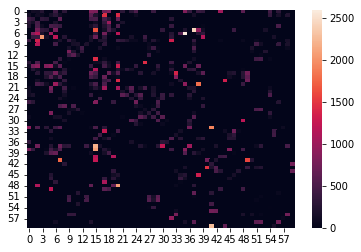

In [38]:
import seaborn

print('Distance error from ground truth: [smol]')
seaborn.heatmap(distance_diff)

Distance estimate cells with no data: [smol]


<AxesSubplot:>

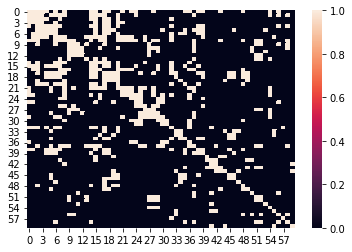

In [39]:
print('Distance estimate cells with no data: [smol]')

distance_not_found = np.zeros_like(distance)

for g1 in range(n_gateways):
    for g2 in range(n_gateways):
        if distance[g1][g2] != 0.0:
            distance_not_found[g1][g2] = 1.0
            
seaborn.heatmap(distance_not_found)

-------

In [435]:
#pick three gateways to triangulate from ground truth
gateway_a = [231.2663,120.1813]
gateway_b = [197.9663,793.9513]
gateway_c = [757.0289,350.5063]

x1 = gateway_a[0]
y1 = gateway_a[1]

x2 = gateway_b[0]
y2 = gateway_b[1]

x3 = gateway_c[0]
y3 = gateway_c[1]



In [436]:
#function to return the distance error between points
def distance_err(point):
    x = point[0]
    y = point[1]
    error1 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x1,y1])) - d1)**2
    error2 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x2,y2])) - d2)**2
    error3 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x3,y3])) - d3)**2
    error_total = error1 + error2 + error3
    
    return error_total 

#Example use of 
#least_squares(fun,[16000,25000])

In [437]:
#for each gateway get the location 
positions_x = []
positions_y = []

#loop through gateways 
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    d1 = distance[i][0]
    d2 = distance[i][27]
    d3 = distance[i][3]
    
    positions_x.append(least_squares(distance_err,[400,400]).x[0])
    positions_y.append(least_squares(distance_err,[400,400]).x[1])

zipped = list(zip(gateway_ids,positions_x,positions_y))
positions = pd.DataFrame(zipped, columns = ['gateway_ids','positions_x','positions_y'])
positions.head()

,gateway_ids,positions_x,positions_y
0,15,302.983685,443.694054
1,34,308.594925,446.036204
2,19,335.257076,485.726544
3,49,443.474941,515.434470
4,9,339.224095,713.579048


In [438]:
##Import the excel file 
truth_df = pd.read_csv('sensors.csv')
truth_df.head()

gateway_ids

#get the ground truth values for the gateway ids of interest
truth_df_filtered = truth_df[truth_df['sensor ID'].isin(gateway_ids)]
truth_df_filtered.head()

,sensor ID,x (m),y (m),radius (m)
0,0,231.2663,120.1813,11.131326
1,1,371.8589,238.2076,11.634567
2,2,757.0289,350.5063,15.115731
3,3,190.9400,140.1613,13.697470
4,4,663.1340,522.3010,14.227241


In [439]:
#get gateway_id position error 

error = np.zeros(60)
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    truth_data = truth_df[truth_df['sensor ID'] == gateway]
    x = truth_data['x (m)'].values
    y = truth_data['y (m)'].values
    
    position_data = positions[positions['gateway_ids'] == gateway]
    x_est = position_data['positions_x'].values
    y_est = position_data['positions_y'].values
    
    error[i] = np.linalg.norm(np.array([x,y])-np.array([x_est,y_est]))
    
print(error)

[500.88478248 480.70238334 467.3191978  450.42051831 559.8955896
 266.97419367 353.10862503 937.94934768 287.71059359 357.13510766
 399.318443   437.7739866  482.04325375 286.0455173  409.09307286
 481.34161196 213.85270487 217.20766582 225.62842278 254.91380439
 186.71114864 300.51109141 274.32222939 299.72494789 301.86854476
 295.54384458 241.16626988 370.94819758 344.06287924 323.86376926
 368.52040651 401.03900499 649.3931879  386.18554012 337.95639409
 359.69908788 399.05762173 186.24364307 796.99566878 372.43550633
 526.1056056  414.3297827  380.74633105 429.06205646 418.38914767
 342.00126719 352.811711   438.0515301   33.37909101 421.51361164
 410.52512583 333.15380282 332.03543036 381.70401895 407.6871241
 558.77988037 252.05510798 529.95698031 238.11174538 437.062473  ]


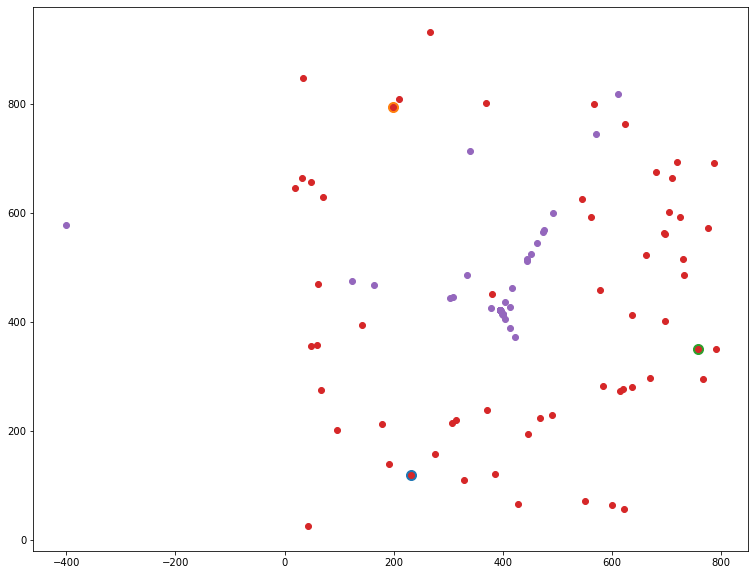

In [440]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(x1,y1,s=100,marker='o')
plt.scatter(x2,y2,s=100,marker='o')
plt.scatter(x3,y3,s=100,marker='o')
plt.scatter(truth_df_filtered["x (m)"], truth_df_filtered["y (m)"])
plt.scatter(positions['positions_x'], positions['positions_y'])
plt.show()

In [ ]:
#bring in other sensor traces 
#figure out your for loopin problem 

In [ ]:
#Unused function to check how many times gateways are next to each other and return average time 
def gateway_adjacent(gateway_x, gateway_y):
    #print(gateway_x)
    #print(gateway_y)
    
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    #print(size)
    for x in range(size):
        if (backbone_sensor_df.iloc[x][0] == gateway_x):
            #if it's the first index 
            if (x == 0):
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
            
            #if it's a last index
            elif (x == size-1):
                if (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
            
            else:
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
                    
    if (count >= 1): 
        return time/count
    else:
        return 0

In [ ]:
#filter to adjadent gateways with a time difference larger than 3 seconds

#take this out? Can we just use the smol attack data directly

#diff_sensor_df = sensor_df_smol.diff()
#print(diff_sensor_df[40:60])
#print(sensor_df_smol[40:60])
#[diff_sensor_df['norm_secs (secs)'] > 5]

#backbone_sensor_df = sensor_df_smol 
#backbone_sensor_df.head()